In [1]:
import trimesh
import neuroglancer_scripts
from meshparty import trimesh_io, skeleton
from scipy import spatial
KDTree = spatial.cKDTree
import nglui
from meshparty import mesh_filters
import more_itertools
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import math
pi = math.pi

In [2]:
# find the up vec for a given x z position

up_vec_dict = {'[0, 0]': np.array([[-0.08441962],
        [-0.99499665],
        [-0.05343209]]),
 '[0, 1]': np.array([[-0.10005934],
        [-0.99490884],
        [-0.01202171]]),
 '[1, 0]': np.array([[-0.07004   ],
        [-0.99654685],
        [-0.04459569]]),
 '[1, 1]': np.array([[-0.06623445],
        [-0.99758491],
        [-0.02091285]]),
 '[2, 0]': np.array([[-0.05101405],
        [-0.99634316],
        [-0.06854106]]),
 '[2, 1]': np.array([[-0.05697568],
        [-0.99829758],
        [-0.01247843]]),
 '[3, 0]': np.array([[-0.05861458],
        [-0.99570275],
        [-0.07169634]]),
 '[3, 1]': np.array([[-0.05276404],
        [-0.99536198],
        [-0.08043928]]),
 '[4, 0]': np.array([[-0.06981194],
        [-0.99213514],
        [-0.10389493]]),
 '[4, 1]': np.array([[-0.05538955],
        [-0.99523631],
        [-0.08022896]]),
 '[5, 0]': np.array([[-0.05357379],
        [-0.99145499],
        [-0.11894051]]),
 '[5, 1]': np.array([[-0.01186356],
        [-0.99573351],
        [-0.09150971]]),
 '[6, 0]': np.array([[-0.05883202],
        [-0.98997358],
        [-0.12841769]]),
 '[6, 1]': np.array([[ 3.94229021e-04],
        [-9.96570021e-01],
        [-8.27528753e-02]])}


x_ranges = [(570112.0, 675958.8571428572),
 (675958.8571428572, 781805.7142857143),
 (781805.7142857143, 887652.5714285714),
 (887652.5714285714, 993499.4285714286),
 (993499.4285714286, 1099346.2857142857),
 (1099346.2857142857, 1205193.1428571427),
 (1205193.1428571427, 1311040.0)]

z_ranges = [(748880.0, 842260.0), (842260.0, 935640.0)]


def find_up_vec(x_pos, z_pos):
    '''
    
    takes x and y position (nm) and returns the corresponding up vector 
    
    '''

    # find row/column combo in the grid of the xz spread of the dataset 
    xz_bin = []
    for i in range(len(x_ranges)):
        if x_ranges[i][0] <= x_pos <= x_ranges[i][1]:
            xz_bin.append(i)
        else:
            continue
    for ii in range(len(z_ranges)):
        if z_ranges[ii][0] <= z_pos <= z_ranges[ii][1]:
            xz_bin.append(ii)
        else:
            continue

    
    return up_vec_dict[str(xz_bin)]


In [3]:
np.array([[-0.06981194],
        [-0.99213514],
        [-0.10389493]]).shape

(3, 1)

In [4]:
np.array([[0],[-1],[0]]).reshape(3,1)

array([[ 0],
       [-1],
       [ 0]])

In [5]:
# functions to create the layer meshes 
def make_layer_poly(mesh_top, mesh_bottom, soma_pos, offset=1000, up_vec = np.array([0,-1,0])):
    # get the vec perp to the plane of up vec and x : 
    verts_top = get_mesh_line(mesh_top, soma_pos, up_vec)
    verts_bot = get_mesh_line(mesh_bottom, soma_pos, up_vec)
    print(len(verts_top))
    print(len(verts_bot))
    verts_top = verts_top[::-1,:] + np.array([0,offset,0])
    verts_bot = verts_bot - np.array([0,offset,0])
    poly_verts= np.concatenate([verts_top, verts_bot])
    return poly_verts


def get_mesh_line(mesh, soma_pos, up_vec = np.array([0,-1,0])):
    up_vec = up_vec.reshape((3,))
    uv_norm = np.cross(up_vec, np.array([1,0,0]).T)
    lines=trimesh.intersections.mesh_plane(mesh, uv_norm, soma_pos)
    lines_con = lines.reshape(lines.shape[0]*lines.shape[1],3)
    
    verts,inv = np.unique(lines_con, axis=0, return_inverse=True)
    lines=inv.reshape(len(inv)//2,2)
    
    tree = KDTree(verts)
    pairs = tree.query_pairs(1)
    for pair in pairs:
        lines[lines==pair[1]]=pair[0]
    
    sk=skeleton.Skeleton(verts,lines,root=np.argmin(verts[:,0]))
    sk=sk.apply_mask(mesh_filters.filter_largest_component(sk))
    
    cp = sk.cover_paths[0]
    verts = sk.vertices[cp]
    return verts

In [6]:
from neuroglancer_scripts.mesh import read_precomputed_mesh
mesh_dict={}
for filepath in ["layer_meshes/l23","layer_meshes/l4","layer_meshes/l5","layer_meshes/l6a","layer_meshes/l6b","layer_meshes/wm"]:
    print(filepath)
    with open(filepath,'rb') as fp:
        verts,faces = read_precomputed_mesh(fp)
    mesh = trimesh_io.Mesh(verts, faces)
    filename = filepath.split('/')[1]
    mesh_dict[filename]=mesh
    

layer_meshes/l23
layer_meshes/l4
layer_meshes/l5
layer_meshes/l6a
layer_meshes/l6b
layer_meshes/wm


In [7]:
pia_mesh = trimesh.load_mesh('layer_meshes/pia3.ply')
mesh_dict['pia'] = pia_mesh
mesh_dict['pia'] = trimesh_io.Mesh(mesh_dict['pia'].vertices * 1_000_000, mesh_dict['pia'].faces)

soma_pos = np.array([1148096.0, 623744.0, 826760.0])

In [576]:
list(mesh_dict.keys())

['l23', 'l4', 'l5', 'l6a', 'l6b', 'wm', 'pia']

In [8]:
up_vec = find_up_vec(x_pos = soma_pos[0], z_pos = soma_pos[2]).reshape(-1)


lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], soma_pos = soma_pos)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], soma_pos = soma_pos)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], soma_pos = soma_pos)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], soma_pos = soma_pos)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6abverts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], soma_pos = soma_pos)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6abverts]})

lay6bwmverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], soma_pos = soma_pos)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bwmverts]})


70
63
63
63
63
63
63
63
63
71
71
63


In [9]:
lay1verts = np.vstack([lay1verts, lay1verts[0]])
lay1verts

array([[ 231483.13378327,  393978.82849798,  826760.        ],
       [ 246506.82444677,  399613.34243612,  826760.        ],
       [ 294398.91200537,  386466.97849136,  826760.        ],
       [ 323774.67022835,  384032.09348135,  826760.        ],
       [ 349445.10696525,  388607.26667227,  826760.        ],
       [ 361583.40927101,  388607.26667227,  826760.        ],
       [ 391838.61298837,  376734.49725362,  826760.        ],
       [ 396462.49881964,  381825.63894966,  826760.        ],
       [ 426390.98562806,  372161.53309251,  826760.        ],
       [ 442306.62564783,  371942.04856097,  826760.        ],
       [ 449336.18058471,  370076.37381148,  826760.        ],
       [ 462024.87325572,  368479.30096287,  826760.        ],
       [ 472444.03410061,  369434.3298368 ,  826760.        ],
       [ 489067.45717887,  368102.27124108,  826760.        ],
       [ 496630.38074506,  369416.99454581,  826760.        ],
       [ 519809.75357892,  366965.25082729,  826760.   

In [10]:
import caveclient 
client = caveclient.CAVEclient('minnie65_phase3_v1')
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['lay1', 'lay23', 'l4', 'l5', 'l6a', 'l6b']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df, lay23df, lay4df, lay5df, lay6adf, lay6bdf], return_as='html')

In [11]:
import caveclient
client = caveclient.CAVEclient('minnie65_phase3_v1')
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['l1']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df], return_as='html')

### Finding the norm to plane to cut mesh using my up vec
- find plane that passes through soma and my up vec
    - that could be any plan rotated about my up vec 
- find that plane that is closest to flat against x axis 
- how to do this - maximize cross product between flat plane norm and my up vec plane norm
- wouldn't it also work to find the plane that goes through my up vec, a vec parallel to x axis, and passes through soma?
- to do that maybe I can shift all coords so that soma is at origion, then shift back up 



- check if bounding box weused lines up with alex's mesh coverage


be comfortable running skeleton keys pipeline 
- run for the cells we already ran using nunos manually defined layer bounds, use my cut ^ of polygons
- should be pretty similar but probably not the same 
- run with docker image - forrest is curious if I can run his docker image that he has pushed to hub 
- F has scripts for creating the python taskqueues 
- I will change some of the parameters - like if I have a different skelton bucket 
- possible to run this locally, at least to test it out 
- generate polygon files for every cell 


In [12]:
# create a new normal vec to use in get_mesh_line
# 

In [13]:
# now I will need to find the normal to the plan that intersects this line and is paralell
# to the z plane 

# so first I can pass my up vec through the soma locaiton and find the intersection with 
# line at z = soma z location 
# find the cross product of these two vectors to get the normal to use in this line : 
#  lines=trimesh.intersections.mesh_plane(mesh, *normal here*, soma_pos)


In [14]:
# get the cross product between this ^ and 1,0,0
np.cross(up_vec.reshape(-1), np.array([[1],[0],[0]]).T)

array([[ 0.        , -0.11894051,  0.99145499]])

In [15]:
# create an example to run through skeleton keys 
# create folders that contain 10 labeled swcs 

In [16]:
#export GOOGLE_APPLICATION_CREDENTIALS = "/Users/emily.joyce/.cloudvolume/secrets/google-secret.json"

In [17]:
# create a function that will take in an swc, find the root location, then create a 
# polygon file 

# does not work
#pd.read_csv('gs://https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/axon_removed/scc_excitatory_csm_swc_relabel/864691135526058843.swc')

In [18]:
#import pandas as pd
#import gcsfs

#fs = gcsfs.GCSFileSystem(project='my-project')
#with fs.open('bucket/path.csv') as f:
#    df = pd.read_csv(f)

In [19]:
# ok so eventually I need to be able to do this. for now I will just export a test and 
# try to get that through everything and use the docker image 

In [20]:
# test cell is 864691135526058843

In [21]:
# so I need to find in soma table 
body_id = 864691135526058843

soma_df = client.materialize.query_table('nucleus_neuron_svm') 

In [22]:
soma_loc = soma_df[soma_df['pt_root_id'] == body_id]['pt_position'].iloc[0]*[4,4,40]
soma_loc

array([734912, 629824, 924440])

In [23]:
# ok great! now I can find the up vector 
up_vec = find_up_vec(soma_loc[0], soma_loc[2]).reshape(-1)
up_vec

array([-0.06623445, -0.99758491, -0.02091285])

In [24]:
# now I will view this state
lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_loc)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_loc)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_loc)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_loc)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6averts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_loc)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6averts]})

lay6bverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_loc)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bverts]})

54
63
63
63
63
63
63
63
63
71
71
63


In [25]:
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['lay1', 'lay23', 'l4', 'l5', 'l6a', 'l6b']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df, lay23df, lay4df, lay5df, lay6adf, lay6bdf], return_as='html')

In [71]:
# yest this does indeed seem slanted. 
# OK! now I need to get this into the correct format. Here is an example
{"pia_path":{"name":"Pia",
             "path":[[880,1071],[928,1064],[979,1055],[1022,1049],[1071,1041],[1119,1033],[1167,1023],[1213,1021],[1261,1014],[1306,1011],[1357,1001],[1406,999],[1455,996],[1507,993],[1581,977],[1640,970],[1690,964],[1744,959],[1801,949],[1857,937],[1914,928],[1967,925],[2012,925],[2062,929],[2279,909],[2346,896],[2410,889],[2470,885],[2527,880],[2584,877],[2650,868],[2703,860],[2758,857],[2815,857],[2875,850],[2924,857],[3119,866],[3176,853],[3227,842],[3284,841],[3342,845],[3401,844],[3456,846],[3515,847],[3573,846],[3637,840],[3693,832],[3759,828],[3817,814],[3910,798],[4108,801],[4350,808]],
             "resolution":0.3603,
             "biospecimen_id":864691134674764538},
 "wm_path":{"name":"White Matter",
            "path":[[1003,3008],[1125,2999],[1224,2992],[1322,2992],[1429,2976],[1580,2976],[1731,2966],[1881,2957],[2032,2941],[2183,2919],[2333,2882],[2484,2872],[2635,2874],[2786,2859],[2936,2849],[3087,2824],[3238,2804],[3389,2787],[3539,2782],[3690,2787],[3841,2783],[3991,2783],[4142,2783],[4249,2801],[4372,2813],[4504,2825]],
            "resolution":0.3603,
            "biospecimen_id":864691134674764538},
 "soma_path":{"name":"Soma",
              "path":[[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]],
              "resolution":0.3603,
              "biospecimen_id":864691134674764538,
              "center":[656.1643075215098,1674.8709408825978]},
 "layer_polygons":[{"path":[[880,1085],[928,1078],[979,1069],[1022,1063],[1071,1055],[1119,1047],[1167,1037],[1213,1035],[1261,1028],[1306,1025],[1357,1015],[1406,1013],[1455,1009],[1507,1007],[1581,991],[1640,983],[1690,978],[1744,973],[1801,963],[1857,951],[1914,942],[1967,939],[2012,939],[2062,943],[2279,922],[2346,909],[2410,903],[2470,899],[2527,894],[2584,891],[2650,882],[2703,874],[2758,870],[2815,870],[2875,864],[2924,870],[3119,880],[3176,867],[3227,856],[3284,855],[3342,859],[3401,857],[3456,860],[3515,861],[3573,860],[3637,854],[3693,846],[3759,842],[3817,828],[3910,812],[4112,817],[4354,825],[4350,1055],[4127,1057],[3949,1070],[3832,1079],[3783,1088],[3590,1104],[3421,1101],[3312,1098],[3162,1101],[3019,1113],[2915,1118],[2813,1126],[2642,1132],[2481,1163],[2351,1172],[2260,1178],[2127,1185],[1979,1183],[1873,1185],[1774,1189],[1669,1208],[1537,1226],[1404,1241],[1259,1252],[1133,1246],[1061,1255],[980,1257],[887,1257],[880,1085]],
                    "name":"Layer1",
                    "resolution":0.3603},
                   {"path":[[4350,1069],[4127,1071],[3949,1084],[3832,1093],[3783,1102],[3590,1118],[3421,1115],[3312,1112],[3162,1115],[3019,1127],[2915,1131],[2813,1140],[2642,1146],[2481,1177],[2351,1186],[2260,1192],[2127,1199],[1979,1197],[1873,1199],[1774,1203],[1669,1222],[1537,1240],[1404,1255],[1259,1266],[1133,1260],[1061,1269],[980,1270],[892,1283],[910,1607],[1009,1595],[1139,1597],[1258,1587],[1429,1573],[1580,1573],[1731,1613],[1881,1579],[2032,1560],[2183,1545],[2333,1549],[2484,1528],[2635,1500],[2786,1418],[2936,1399],[3087,1426],[3238,1430],[3389,1385],[3539,1359],[3690,1370],[3841,1390],[3991,1390],[4142,1390],[4368,1378],[4350,1069]],
                    "name":"Layer2/3",
                    "resolution":0.3603},
                   {"path":[[4368,1392],[4142,1404],[3991,1404],[3841,1404],[3690,1384],[3539,1373],[3389,1399],[3238,1444],[3087,1440],[2936,1413],[2786,1432],[2635,1514],[2484,1542],[2333,1562],[2183,1559],[2032,1574],[1881,1593],[1731,1627],[1580,1587],[1429,1587],[1258,1600],[1139,1611],[1009,1609],[910,1621],[948,1972],[1037,1984],[1104,1978],[1187,1975],[1279,1965],[1429,1954],[1580,1954],[1731,1947],[1881,1937],[2032,1928],[2183,1918],[2333,1896],[2484,1893],[2635,1860],[2786,1843],[2936,1833],[3087,1789],[3238,1775],[3389,1760],[3539,1727],[3690,1699],[3841,1689],[3991,1689],[4142,1689],[4391,1679],[4368,1392]],
                    "name":"Layer4",
                    "resolution":0.3603},
                   {"path":[[4400,1711],[4142,1703],[3991,1703],[3841,1703],[3690,1713],[3539,1741],[3389,1774],[3238,1789],[3087,1803],[2936,1847],[2786,1857],[2635,1873],[2484,1906],[2333,1910],[2183,1932],[2032,1942],[1881,1951],[1731,1961],[1580,1968],[1429,1968],[1279,1979],[1187,1989],[1104,1992],[1037,1998],[948,1986],[972,2489],[1104,2476],[1208,2470],[1316,2458],[1429,2444],[1580,2444],[1731,2392],[1881,2341],[2032,2317],[2183,2327],[2333,2339],[2484,2316],[2635,2293],[2786,2271],[2936,2256],[3087,2298],[3238,2217],[3389,2178],[3539,2183],[3690,2183],[3841,2197],[3991,2197],[4142,2197],[4436,2193],[4400,1711]],
                    "name":"Layer5",
                    "resolution":0.3603},
                   {"path":[[4443,2226],[4142,2211],[3991,2211],[3841,2211],[3690,2196],[3539,2196],[3389,2192],[3238,2231],[3087,2312],[2936,2270],[2786,2285],[2635,2307],[2484,2330],[2333,2353],[2183,2341],[2032,2330],[1881,2355],[1731,2406],[1580,2458],[1429,2458],[1316,2472],[1208,2484],[1104,2490],[972,2502],[984,2888],[1046,2882],[1141,2879],[1242,2854],[1368,2867],[1466,2870],[1573,2851],[1690,2839],[1783,2816],[1846,2811],[1908,2811],[1971,2816],[2034,2816],[2096,2805],[2159,2784],[2222,2773],[2284,2766],[2347,2757],[2410,2756],[2472,2752],[2535,2745],[2598,2740],[2660,2732],[2723,2716],[2786,2700],[2848,2680],[2911,2673],[2974,2661],[3036,2651],[3099,2638],[3162,2649],[3224,2658],[3287,2660],[3350,2658],[3412,2649],[3475,2642],[3538,2640],[3600,2641],[3721,2654],[3850,2657],[3976,2675],[4093,2672],[4237,2663],[4363,2657],[4495,2650],[4443,2226]],
                    "name":"Layer6a",
                    "resolution":0.3603},
                   {"path":[[4504,2689],[4363,2671],[4237,2677],[4093,2686],[3976,2689],[3850,2671],[3721,2668],[3600,2655],[3538,2654],[3475,2655],[3412,2663],[3350,2671],[3287,2674],[3224,2672],[3162,2663],[3099,2652],[3036,2665],[2974,2675],[2911,2687],[2848,2694],[2786,2714],[2723,2730],[2660,2746],[2598,2754],[2535,2758],[2472,2765],[2410,2769],[2347,2771],[2284,2780],[2222,2787],[2159,2798],[2096,2819],[2034,2830],[1971,2830],[1908,2825],[1846,2825],[1783,2830],[1690,2853],[1573,2865],[1466,2884],[1368,2880],[1242,2868],[1141,2893],[1046,2896],[984,2902],[1003,2994],[1125,2985],[1224,2978],[1322,2978],[1429,2962],[1580,2962],[1731,2953],[1881,2943],[2032,2927],[2183,2905],[2333,2868],[2484,2858],[2635,2860],[2786,2845],[2936,2835],[3087,2810],[3238,2790],[3389,2773],[3539,2769],[3690,2773],[3841,2769],[3991,2769],[4142,2769],[4249,2787],[4372,2799],[4504,2812],[4504,2689]],
                    "name":"Layer6b",
                    "resolution":0.3603}]}






{'pia_path': {'name': 'Pia',
  'path': [[880, 1071],
   [928, 1064],
   [979, 1055],
   [1022, 1049],
   [1071, 1041],
   [1119, 1033],
   [1167, 1023],
   [1213, 1021],
   [1261, 1014],
   [1306, 1011],
   [1357, 1001],
   [1406, 999],
   [1455, 996],
   [1507, 993],
   [1581, 977],
   [1640, 970],
   [1690, 964],
   [1744, 959],
   [1801, 949],
   [1857, 937],
   [1914, 928],
   [1967, 925],
   [2012, 925],
   [2062, 929],
   [2279, 909],
   [2346, 896],
   [2410, 889],
   [2470, 885],
   [2527, 880],
   [2584, 877],
   [2650, 868],
   [2703, 860],
   [2758, 857],
   [2815, 857],
   [2875, 850],
   [2924, 857],
   [3119, 866],
   [3176, 853],
   [3227, 842],
   [3284, 841],
   [3342, 845],
   [3401, 844],
   [3456, 846],
   [3515, 847],
   [3573, 846],
   [3637, 840],
   [3693, 832],
   [3759, 828],
   [3817, 814],
   [3910, 798],
   [4108, 801],
   [4350, 808]],
  'resolution': 0.3603,
  'biospecimen_id': 864691134674764538},
 'wm_path': {'name': 'White Matter',
  'path': [[1003, 30

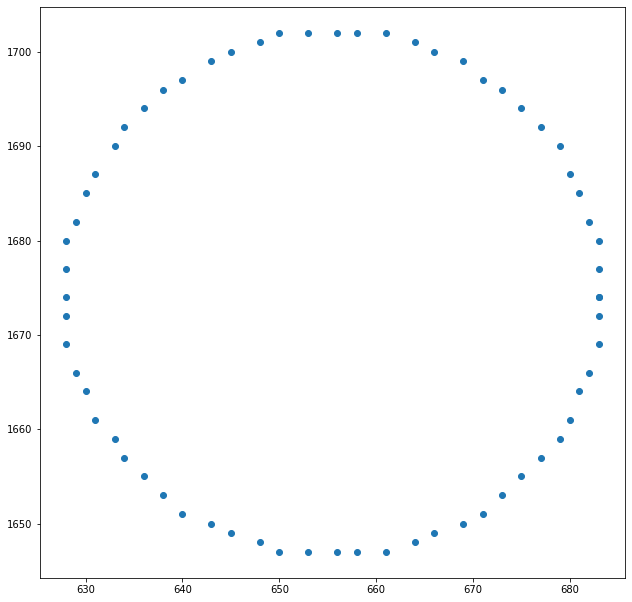

In [26]:
# need to calculate soma path 
# let me map out the example soma path

from matplotlib import pyplot

fig, ax = pyplot.subplots()
fig.set_size_inches(10.5, 10.5)
points = np.array([[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]])
ax.scatter(x = points[:,0], y = points[:,1])

In [27]:
# make function to get soma polygon
def calculate_soma_poly(soma_loc, n, r):
    '''
    returns n number of points evenly spaced around radius r circle from soma location
    
    '''
    
    return np.array([(math.cos(2*pi/n*x)*r + soma_loc[0], math.sin(2*pi/n*x)*r + soma_loc[2]) for x in range(0,n+1)])
    
    
    

In [28]:
points2 = calculate_soma_poly(soma_loc, 65, 25)
points2.shape

(66, 2)

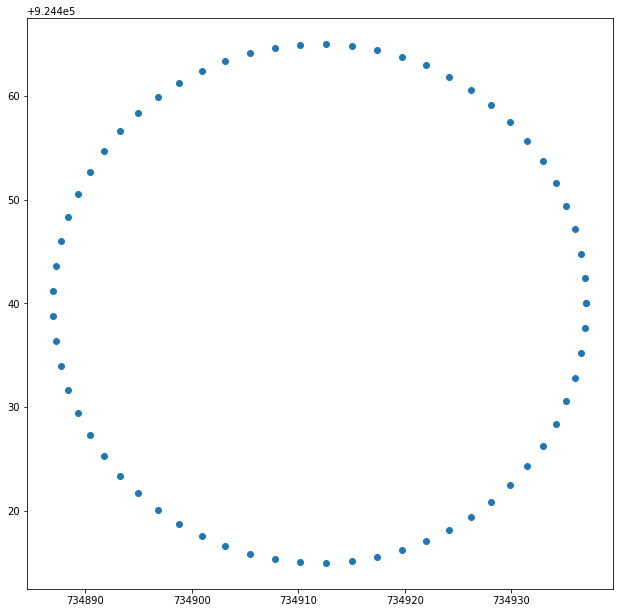

In [29]:

fig, ax = pyplot.subplots()
fig.set_size_inches(10.5, 10.5)
ax.scatter(x = points2[:,0], y = points2[:,1])

In [30]:
# now I will view this state
lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_loc)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_loc)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_loc)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_loc)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6averts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_loc)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6averts]})

lay6bverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_loc)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bverts]})

54
63
63
63
63
63
63
63
63
71
71
63


In [31]:
np.array([1,2,3]).shape

(3,)

In [578]:
soma_pos.shape

(3,)

In [33]:
def make_poly_file(soma_pos, specimen_id, n_soma_circ_pts = 65, soma_rad = 2500, res = 0.3603):
    
    '''
    soma_pos must be in nm nad roughly between these values:
    x: 570112-1311040
    z: 748880-935640
    
    
    '''
    # create teh empty poly dict to be filled
    poly_dict = {}
    
    # create empty sub dicts/lists which will be filled then entered into poly dict
    pia_dict = {}
    wm_dict = {}
    soma_dict = {}
    layer_polygons_list = []
    # now create the layer polygons subdicts
    layer1_dict = {}
    layer2_3_dict = {}
    layer4_dict = {}
    layer5_dict = {}
    layer6a_dict = {}
    layer6b_dict = {}

    # find the up vector 
    up_vec = np.array(find_up_vec(soma_pos[0], soma_pos[2]))
    # calculate layer verts
    
    pia_verts = np.around(get_mesh_line(mesh_dict['pia'], soma_pos, up_vec=up_vec)[:,0:2]/[1000*res,1000*res])
    lay1verts = np.around(make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay23verts = np.around(make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay4verts = np.around(make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay5verts = np.around(make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay6averts = np.around(make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay6bverts = np.around(make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    wm_verts = np.around(get_mesh_line(mesh_dict['wm'], soma_pos, up_vec=up_vec)[:,0:2]/[1000*res,1000*res])
    
    # fill out pia dict
    pia_dict['name'] = "Pia"
    pia_dict['path'] = pia_verts.tolist()
    pia_dict['resolution'] = res
    pia_dict['biospecimen_id'] = specimen_id
    # insert pia dict into main poly dict 
    poly_dict['pia_path'] = pia_dict
    
    # fill out white matter dict 
    wm_dict['name'] = "White Matter"
    wm_dict['path'] = wm_verts.tolist()
    wm_dict['resolution'] = res
    wm_dict['biospecimen_id'] = specimen_id
    # insert wm_dict to poly_dict
    poly_dict['wm_path'] = pia_dict
    
    # now do the soma path 
    soma_dict['name'] = "Soma"
    soma_dict['path'] = np.around(calculate_soma_poly(soma_loc, n_soma_circ_pts, soma_rad)/[1000*res,1000*res]).tolist()
    soma_dict['resolution'] = res
    soma_dict['biospecimen_id'] = specimen_id 
    soma_dict['center'] =  [soma_pos[0], soma_pos[2]]
    # insert to larger ditc
    poly_dict['soma_path'] = soma_dict
    
    # now fill out the larger layer_polygons_dict
    # layer by layer 
    layer1_dict['path'] = lay1verts.tolist()
    layer1_dict['name'] = 'Layer1'
    layer1_dict['resolution'] = res
    
    layer2_3_dict['path'] = lay23verts.tolist()
    layer2_3_dict['name'] = 'Layer2/3'
    layer2_3_dict['resolution'] = res
    
    layer4_dict['path'] = lay4verts.tolist()
    layer4_dict['name'] = 'Layer4'
    layer4_dict['resolution'] = res

    layer5_dict['path'] = lay5verts.tolist()
    layer5_dict['name'] = 'Layer5'
    layer5_dict['resolution'] = res

    layer6a_dict['path'] = lay6averts.tolist()
    layer6a_dict['name'] = 'Layer6a'
    layer6a_dict['resolution'] = res
    
    layer6b_dict['path'] = lay6bverts.tolist()
    layer6b_dict['name'] = 'Layer6b'
    layer6b_dict['resolution'] = res
    
    #insert all of the above into layer_polygons_list
    layer_polygons_list.append(layer1_dict)
    layer_polygons_list.append(layer2_3_dict)
    layer_polygons_list.append(layer4_dict)
    layer_polygons_list.append(layer5_dict)
    layer_polygons_list.append(layer6a_dict)
    layer_polygons_list.append(layer6b_dict)

    # insert the layer_polygons_list into poly_dict
    poly_dict['layer_polygons'] = layer_polygons_list

    
    return poly_dict
    
    
    
    


In [34]:
soma_loc
up_vec = find_up_vec(soma_loc[0], soma_loc[2])
body_id = 864691135526058843
test_poly = make_poly_file(soma_pos = np.array([1148096.,  623744.,  826760.]), 
               specimen_id = 864691135526058843, n_soma_circ_pts = 65, 
               soma_rad = 25, res = 0.3603)
test_poly

66
63
63
63
63
65
65
63
63
71
71
63


{'pia_path': {'name': 'Pia',
  'path': [[4105.0, 878.0],
   [4080.0, 895.0],
   [4061.0, 890.0],
   [3958.0, 890.0],
   [3917.0, 883.0],
   [3882.0, 886.0],
   [3744.0, 886.0],
   [3726.0, 886.0],
   [3691.0, 891.0],
   [3609.0, 899.0],
   [3537.0, 901.0],
   [3493.0, 898.0],
   [3475.0, 907.0],
   [3430.0, 910.0],
   [3381.0, 904.0],
   [3335.0, 898.0],
   [3297.0, 901.0],
   [3200.0, 900.0],
   [3146.0, 903.0],
   [3083.0, 902.0],
   [3043.0, 894.0],
   [2980.0, 888.0],
   [2951.0, 884.0],
   [2919.0, 888.0],
   [2852.0, 884.0],
   [2816.0, 888.0],
   [2770.0, 889.0],
   [2711.0, 894.0],
   [2602.0, 905.0],
   [2555.0, 916.0],
   [2510.0, 929.0],
   [2480.0, 936.0],
   [2407.0, 953.0],
   [2390.0, 955.0],
   [2287.0, 984.0],
   [2279.0, 984.0],
   [2272.0, 985.0],
   [2264.0, 987.0],
   [2146.0, 993.0],
   [2138.0, 993.0],
   [2021.0, 997.0],
   [2018.0, 997.0],
   [2003.0, 997.0],
   [1903.0, 994.0],
   [1750.0, 996.0],
   [1744.0, 995.0],
   [1731.0, 996.0],
   [1714.0, 999.0],
   

In [35]:
# Here is the comparison poly

comp_poly = {"pia_path":{"name":"Pia",
             "path":[[880,1071],[928,1064],[979,1055],[1022,1049],[1071,1041],[1119,1033],[1167,1023],[1213,1021],[1261,1014],[1306,1011],[1357,1001],[1406,999],[1455,996],[1507,993],[1581,977],[1640,970],[1690,964],[1744,959],[1801,949],[1857,937],[1914,928],[1967,925],[2012,925],[2062,929],[2279,909],[2346,896],[2410,889],[2470,885],[2527,880],[2584,877],[2650,868],[2703,860],[2758,857],[2815,857],[2875,850],[2924,857],[3119,866],[3176,853],[3227,842],[3284,841],[3342,845],[3401,844],[3456,846],[3515,847],[3573,846],[3637,840],[3693,832],[3759,828],[3817,814],[3910,798],[4108,801],[4350,808]],
             "resolution":0.3603,
             "biospecimen_id":864691134674764538},
 "wm_path":{"name":"White Matter",
            "path":[[1003,3008],[1125,2999],[1224,2992],[1322,2992],[1429,2976],[1580,2976],[1731,2966],[1881,2957],[2032,2941],[2183,2919],[2333,2882],[2484,2872],[2635,2874],[2786,2859],[2936,2849],[3087,2824],[3238,2804],[3389,2787],[3539,2782],[3690,2787],[3841,2783],[3991,2783],[4142,2783],[4249,2801],[4372,2813],[4504,2825]],
            "resolution":0.3603,
            "biospecimen_id":864691134674764538},
 "soma_path":{"name":"Soma",
              "path":[[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]],
              "resolution":0.3603,
              "biospecimen_id":864691134674764538,
              "center":[656.1643075215098,1674.8709408825978]},
 "layer_polygons":[{"path":[[880,1085],[928,1078],[979,1069],[1022,1063],[1071,1055],[1119,1047],[1167,1037],[1213,1035],[1261,1028],[1306,1025],[1357,1015],[1406,1013],[1455,1009],[1507,1007],[1581,991],[1640,983],[1690,978],[1744,973],[1801,963],[1857,951],[1914,942],[1967,939],[2012,939],[2062,943],[2279,922],[2346,909],[2410,903],[2470,899],[2527,894],[2584,891],[2650,882],[2703,874],[2758,870],[2815,870],[2875,864],[2924,870],[3119,880],[3176,867],[3227,856],[3284,855],[3342,859],[3401,857],[3456,860],[3515,861],[3573,860],[3637,854],[3693,846],[3759,842],[3817,828],[3910,812],[4112,817],[4354,825],[4350,1055],[4127,1057],[3949,1070],[3832,1079],[3783,1088],[3590,1104],[3421,1101],[3312,1098],[3162,1101],[3019,1113],[2915,1118],[2813,1126],[2642,1132],[2481,1163],[2351,1172],[2260,1178],[2127,1185],[1979,1183],[1873,1185],[1774,1189],[1669,1208],[1537,1226],[1404,1241],[1259,1252],[1133,1246],[1061,1255],[980,1257],[887,1257],[880,1085]],
                    "name":"Layer1",
                    "resolution":0.3603},
                   {"path":[[4350,1069],[4127,1071],[3949,1084],[3832,1093],[3783,1102],[3590,1118],[3421,1115],[3312,1112],[3162,1115],[3019,1127],[2915,1131],[2813,1140],[2642,1146],[2481,1177],[2351,1186],[2260,1192],[2127,1199],[1979,1197],[1873,1199],[1774,1203],[1669,1222],[1537,1240],[1404,1255],[1259,1266],[1133,1260],[1061,1269],[980,1270],[892,1283],[910,1607],[1009,1595],[1139,1597],[1258,1587],[1429,1573],[1580,1573],[1731,1613],[1881,1579],[2032,1560],[2183,1545],[2333,1549],[2484,1528],[2635,1500],[2786,1418],[2936,1399],[3087,1426],[3238,1430],[3389,1385],[3539,1359],[3690,1370],[3841,1390],[3991,1390],[4142,1390],[4368,1378],[4350,1069]],
                    "name":"Layer2/3",
                    "resolution":0.3603},
                   {"path":[[4368,1392],[4142,1404],[3991,1404],[3841,1404],[3690,1384],[3539,1373],[3389,1399],[3238,1444],[3087,1440],[2936,1413],[2786,1432],[2635,1514],[2484,1542],[2333,1562],[2183,1559],[2032,1574],[1881,1593],[1731,1627],[1580,1587],[1429,1587],[1258,1600],[1139,1611],[1009,1609],[910,1621],[948,1972],[1037,1984],[1104,1978],[1187,1975],[1279,1965],[1429,1954],[1580,1954],[1731,1947],[1881,1937],[2032,1928],[2183,1918],[2333,1896],[2484,1893],[2635,1860],[2786,1843],[2936,1833],[3087,1789],[3238,1775],[3389,1760],[3539,1727],[3690,1699],[3841,1689],[3991,1689],[4142,1689],[4391,1679],[4368,1392]],
                    "name":"Layer4",
                    "resolution":0.3603},
                   {"path":[[4400,1711],[4142,1703],[3991,1703],[3841,1703],[3690,1713],[3539,1741],[3389,1774],[3238,1789],[3087,1803],[2936,1847],[2786,1857],[2635,1873],[2484,1906],[2333,1910],[2183,1932],[2032,1942],[1881,1951],[1731,1961],[1580,1968],[1429,1968],[1279,1979],[1187,1989],[1104,1992],[1037,1998],[948,1986],[972,2489],[1104,2476],[1208,2470],[1316,2458],[1429,2444],[1580,2444],[1731,2392],[1881,2341],[2032,2317],[2183,2327],[2333,2339],[2484,2316],[2635,2293],[2786,2271],[2936,2256],[3087,2298],[3238,2217],[3389,2178],[3539,2183],[3690,2183],[3841,2197],[3991,2197],[4142,2197],[4436,2193],[4400,1711]],
                    "name":"Layer5",
                    "resolution":0.3603},
                   {"path":[[4443,2226],[4142,2211],[3991,2211],[3841,2211],[3690,2196],[3539,2196],[3389,2192],[3238,2231],[3087,2312],[2936,2270],[2786,2285],[2635,2307],[2484,2330],[2333,2353],[2183,2341],[2032,2330],[1881,2355],[1731,2406],[1580,2458],[1429,2458],[1316,2472],[1208,2484],[1104,2490],[972,2502],[984,2888],[1046,2882],[1141,2879],[1242,2854],[1368,2867],[1466,2870],[1573,2851],[1690,2839],[1783,2816],[1846,2811],[1908,2811],[1971,2816],[2034,2816],[2096,2805],[2159,2784],[2222,2773],[2284,2766],[2347,2757],[2410,2756],[2472,2752],[2535,2745],[2598,2740],[2660,2732],[2723,2716],[2786,2700],[2848,2680],[2911,2673],[2974,2661],[3036,2651],[3099,2638],[3162,2649],[3224,2658],[3287,2660],[3350,2658],[3412,2649],[3475,2642],[3538,2640],[3600,2641],[3721,2654],[3850,2657],[3976,2675],[4093,2672],[4237,2663],[4363,2657],[4495,2650],[4443,2226]],
                    "name":"Layer6a",
                    "resolution":0.3603},
                   {"path":[[4504,2689],[4363,2671],[4237,2677],[4093,2686],[3976,2689],[3850,2671],[3721,2668],[3600,2655],[3538,2654],[3475,2655],[3412,2663],[3350,2671],[3287,2674],[3224,2672],[3162,2663],[3099,2652],[3036,2665],[2974,2675],[2911,2687],[2848,2694],[2786,2714],[2723,2730],[2660,2746],[2598,2754],[2535,2758],[2472,2765],[2410,2769],[2347,2771],[2284,2780],[2222,2787],[2159,2798],[2096,2819],[2034,2830],[1971,2830],[1908,2825],[1846,2825],[1783,2830],[1690,2853],[1573,2865],[1466,2884],[1368,2880],[1242,2868],[1141,2893],[1046,2896],[984,2902],[1003,2994],[1125,2985],[1224,2978],[1322,2978],[1429,2962],[1580,2962],[1731,2953],[1881,2943],[2032,2927],[2183,2905],[2333,2868],[2484,2858],[2635,2860],[2786,2845],[2936,2835],[3087,2810],[3238,2790],[3389,2773],[3539,2769],[3690,2773],[3841,2769],[3991,2769],[4142,2769],[4249,2787],[4372,2799],[4504,2812],[4504,2689]],
                    "name":"Layer6b",
                    "resolution":0.3603}]}



In [36]:
test_poly.keys() == comp_poly.keys()

True

In [38]:
# import the up_vecs json as a dict


with open('/Users/emily.joyce/Work/Repos/code_review/skeleton_keys_files/skeleton_keys_excitatory_features/polygon_creation/up_vecs.json') as json_file:
    data = json.load(json_file)
data

{'[0, 0]': [[-0.08441962], [-0.99499665], [-0.05343209]],
 '[0, 1]': [[-0.10005934], [-0.99490884], [-0.01202171]],
 '[1, 0]': [[-0.07004], [-0.99654685], [-0.04459569]],
 '[1, 1]': [[-0.06623445], [-0.99758491], [-0.02091285]],
 '[2, 0]': [[-0.05101405], [-0.99634316], [-0.06854106]],
 '[2, 1]': [[-0.05697568], [-0.99829758], [-0.01247843]],
 '[3, 0]': [[-0.05861458], [-0.99570275], [-0.07169634]],
 '[3, 1]': [[-0.05276404], [-0.99536198], [-0.08043928]],
 '[4, 0]': [[-0.06981194], [-0.99213514], [-0.10389493]],
 '[4, 1]': [[-0.05538955], [-0.99523631], [-0.08022896]],
 '[5, 0]': [[-0.05357379], [-0.99145499], [-0.11894051]],
 '[5, 1]': [[-0.01186356], [-0.99573351], [-0.09150971]],
 '[6, 0]': [[-0.05883202], [-0.98997358], [-0.12841769]],
 '[6, 1]': [[0.000394229021], [-0.996570021], [-0.0827528753]]}

In [584]:
# now I am putting all these files into a .py file and testing the functions below.
%load_ext autoreload
%autoreload 2


.DS_Store
pia3.ply
l4
l5
wm
l6a
l23
l6b
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [585]:
import polygon_creation


In [625]:
t_poly = polygon_creation.make_poly_file(mesh_dict, soma_pos, specimen_id = 1, n_soma_circ_pts = 65, soma_rad = 2500, res = 0.3603)

In [137]:
test_poly = polygon_creation.make_poly_file(soma_pos = np.array([1148096.,  623744.,  826760.]), 
               specimen_id = 864691135526058843, n_soma_circ_pts = 65, 
               soma_rad = 2500, res = 0.3603)

In [112]:
def plot_layer_polygon(ax, surfaces_and_paths):
    pia_surface = surfaces_and_paths["pia_path"]
    wm_surface = surfaces_and_paths["wm_path"]
    soma_drawing = surfaces_and_paths["soma_path"]
    layer_polygons = surfaces_and_paths["layer_polygons"]

    path = np.array(pia_surface["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    path = np.array(wm_surface["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    path = np.array(soma_drawing["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    for poly in layer_polygons:
        path = np.array(poly["path"]) * pia_surface["resolution"]
        ax.plot(path[:, 0], path[:, 1])

<IPython.core.display.Javascript object>


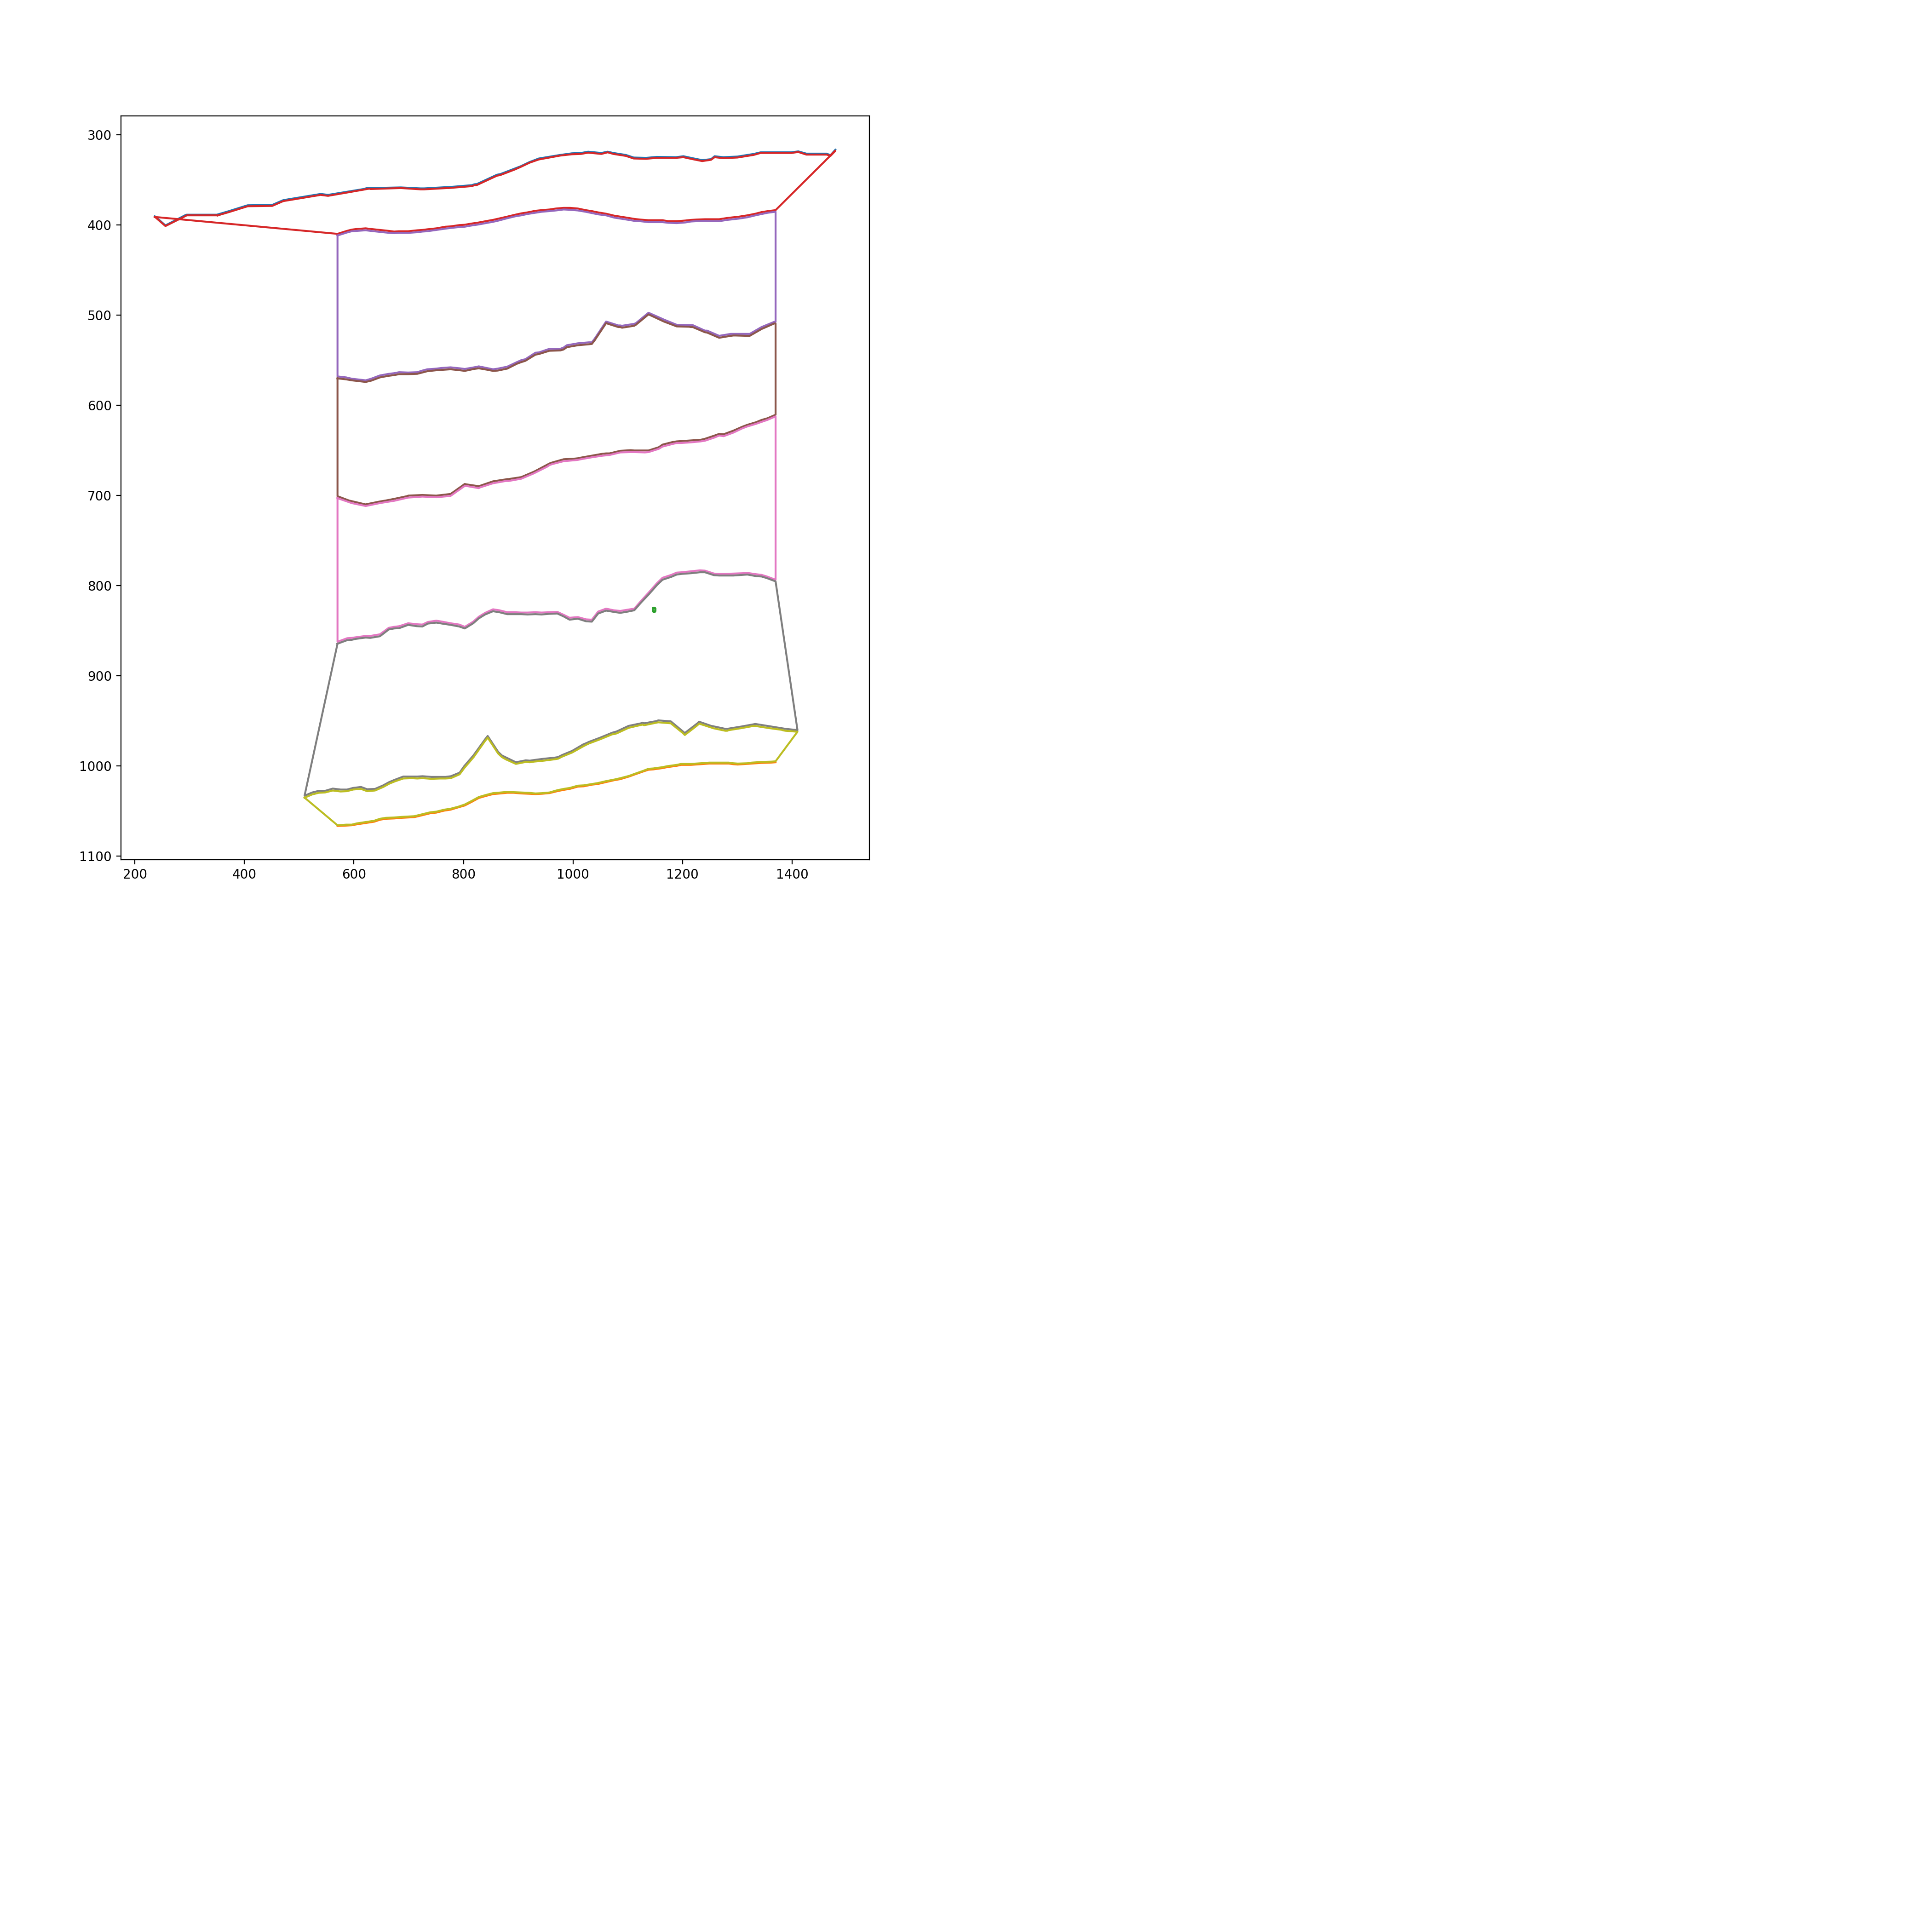

In [113]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
#plt.xlim([3180.0, 3196.0])
#plt.ylim([2295.0, 2295.0])
ax.invert_yaxis()
plot_layer_polygon(ax, test_poly)

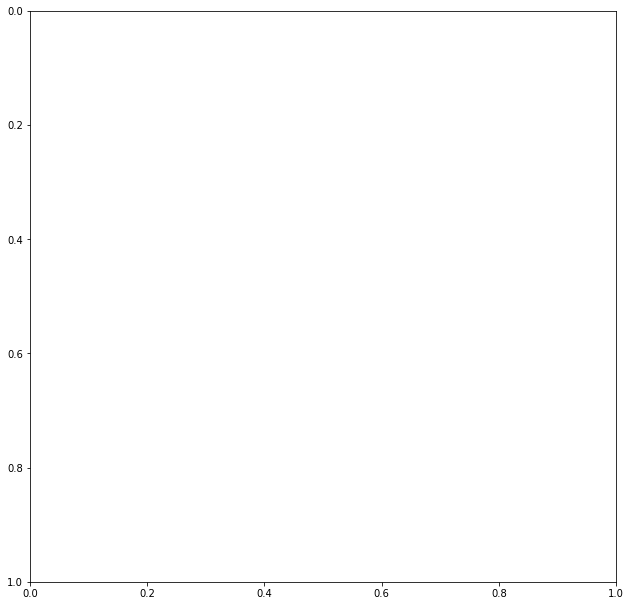

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
#plt.xlim([3180.0, 3196.0])
#plt.ylim([2295.0, 2295.0])
ax.invert_yaxis()



In [172]:
range_min

array([1582.32583958, 2078.4901471 ])

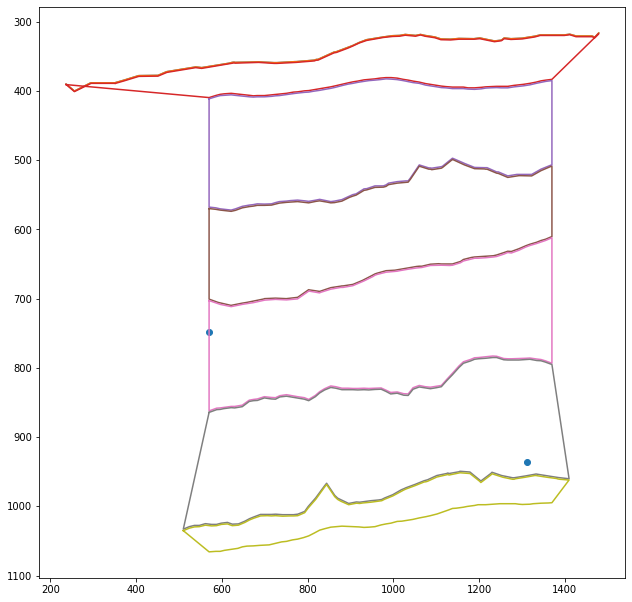

In [224]:
# I want to plot the two diagonal edges of these ranges to see how 
# much is covered by these layers ^ 
x_ranges, z_ranges
range_min = np.array([570112.0, 748880.0])/[1000*res,1000*res]*res
range_max = np.array([1311040.0, 935640.0])/[1000*res,1000*res]*res

# plot those 
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
plot_layer_polygon(ax, test_poly)
ax.invert_yaxis()


ax.scatter(x = [range_min[0], range_max[0]], y = [range_min[1], range_max[1]])

In [229]:
test_poly

OrderedDict([('pia_path',
              OrderedDict([('name', 'Pia'),
                           ('path',
                            [[4105.0, 878.0],
                             [4080.0, 895.0],
                             [4061.0, 890.0],
                             [3958.0, 890.0],
                             [3917.0, 883.0],
                             [3882.0, 886.0],
                             [3744.0, 886.0],
                             [3726.0, 886.0],
                             [3691.0, 891.0],
                             [3609.0, 899.0],
                             [3537.0, 901.0],
                             [3493.0, 898.0],
                             [3475.0, 907.0],
                             [3430.0, 910.0],
                             [3381.0, 904.0],
                             [3335.0, 898.0],
                             [3297.0, 901.0],
                             [3200.0, 900.0],
                             [3146.0, 903.0],
                    

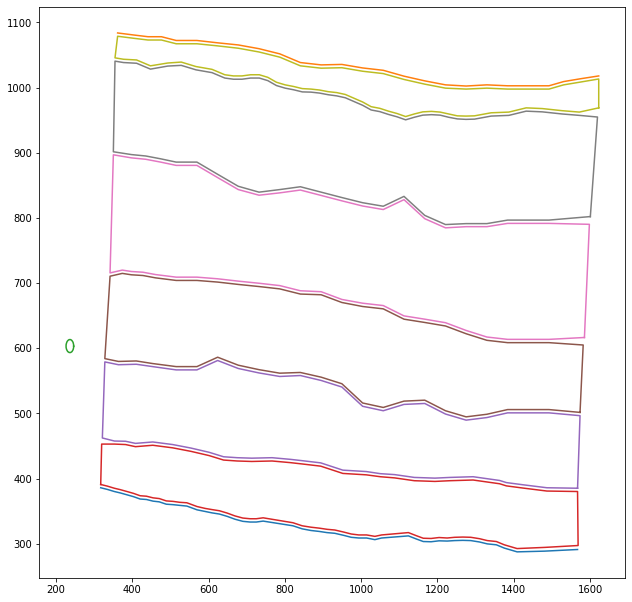

In [192]:
# so this is layer 4 and layer 5 p cells range - looks pretty ok here.
# look into what is happening with the lines on the right and left? like 
# wtf 
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)

surfaces_and_paths = comp_poly

pia_surface = surfaces_and_paths["pia_path"]
wm_surface = surfaces_and_paths["wm_path"]
soma_drawing = surfaces_and_paths["soma_path"]
layer_polygons = surfaces_and_paths["layer_polygons"]

path = np.array(pia_surface["path"]) * pia_surface["resolution"]
ax.plot(path[:, 0], path[:, 1])
path = np.array(wm_surface["path"]) * pia_surface["resolution"]
ax.plot(path[:, 0], path[:, 1])
path = np.array(soma_drawing["path"]) * pia_surface["resolution"]
ax.plot(path[:, 0], path[:, 1])
for poly in layer_polygons:
    path = np.array(poly["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])

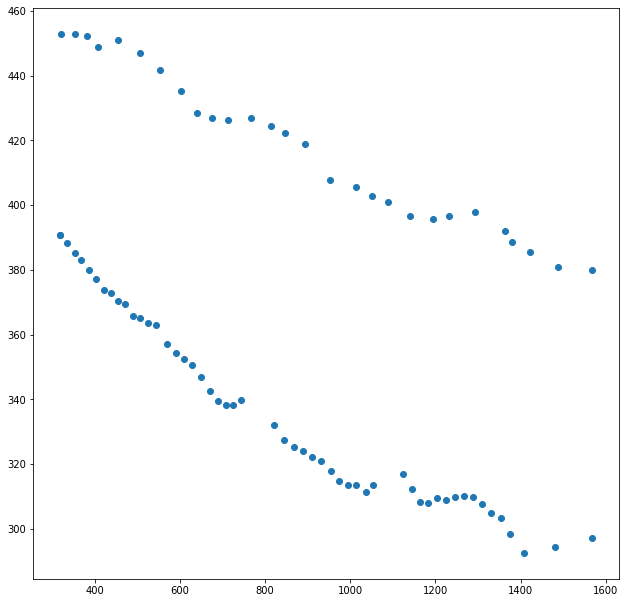

In [221]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)


for poly in layer_polygons[0:1]:
    path = np.array(poly["path"]) * pia_surface["resolution"]
    ax.scatter(path[:, 0], path[:, 1])

In [202]:
# ok this is because I need to add the first vert to the end (repeated)
# so that it will close the loop 

# ok that is done! so let me try running this thorugh skeleton keys 

In [241]:
# re-export the json 
soma_loc
up_vec = polygon_creation.find_up_vec(soma_loc[0], soma_loc[2])
body_id = 864691135526058843
test_poly = polygon_creation.make_poly_file(soma_pos = np.array([1148096.,  623744.,  826760.]), 
               specimen_id = 864691135526058843, n_soma_circ_pts = 65, 
               soma_rad = 25, res = 0.3603)
test_poly

f = open("../layer_aligned_creation/864691135526058843_files/864691135526058843_poly.json", "w")
json.dump(test_poly, f)
f.close()

In [239]:
test_poly

OrderedDict([('pia_path',
              OrderedDict([('name', 'Pia'),
                           ('path',
                            [[4105.0, 878.0],
                             [4080.0, 895.0],
                             [4061.0, 890.0],
                             [3958.0, 890.0],
                             [3917.0, 883.0],
                             [3882.0, 886.0],
                             [3744.0, 886.0],
                             [3726.0, 886.0],
                             [3691.0, 891.0],
                             [3609.0, 899.0],
                             [3537.0, 901.0],
                             [3493.0, 898.0],
                             [3475.0, 907.0],
                             [3430.0, 910.0],
                             [3381.0, 904.0],
                             [3335.0, 898.0],
                             [3297.0, 901.0],
                             [3200.0, 900.0],
                             [3146.0, 903.0],
                    

In [214]:
# this final closing loop vert is being reorder when exported

from collections import OrderedDict

In [216]:
d = OrderedDict()
d['hi'] = 'hello'
d

OrderedDict([('hi', 'hello')])

In [ ]:
# to try next:

# extend the edges to be equal to pia (or even more?)
# so that the straight line drawn down is ok 


In [242]:
# to do 
# change alex's code to extend his meshes 
# take his rows and columns, go x by x and extend the lines out 
# then go z by z and extend those as well 

# to do now
# find x and z range for the whole dataset using soma locations without cutoffs 

In [41]:
minmax_loc_df = pd.DataFrame()

minmax_loc_df['type'] = ['somas; whole dataset']
minmax_loc_df['x min'] = [min([xyz[0] for xyz in soma_df['pt_position']])]
minmax_loc_df['x max'] = [max([xyz[0] for xyz in soma_df['pt_position']])]

minmax_loc_df['z min'] = [min([xyz[2] for xyz in soma_df['pt_position']])]
minmax_loc_df['z max'] = [max([xyz[2] for xyz in soma_df['pt_position']])]


# now add the mins and maxes for each layer mesh 
count = 1
for mesh_name in mesh_dict.keys():
    print(mesh_name)
    minmax_loc_df.loc[count, 'type'] = [mesh_name]
    minmax_loc_df.loc[count, 'x min'] = min([xyz[0]/4 for xyz in mesh_dict[mesh_name].vertices])
    minmax_loc_df.loc[count, 'x max'] = max([xyz[0]/4 for xyz in mesh_dict[mesh_name].vertices])

    minmax_loc_df.loc[count, 'z min'] = min([xyz[2]/40 for xyz in mesh_dict[mesh_name].vertices])
    minmax_loc_df.loc[count, 'z max'] = max([xyz[2]/40 for xyz in mesh_dict[mesh_name].vertices])
    
    count += 1


minmax_loc_df

l23
l4
l5
l6a
l6b
wm
pia


,type,x min,x max,z min,z max
0,somas; whole dataset,48336.000000,434384.000000,14826.000000,27879.000000
1,l23,142500.000000,342500.000000,16250.000000,26250.000000
2,l4,142500.000000,342500.000000,16250.000000,26250.000000
3,l5,142500.000000,342500.000000,16250.000000,26250.000000
4,l6a,142500.000000,342500.000000,16250.000000,26250.000000
5,l6b,127500.000000,352500.000000,16250.000000,26250.000000
6,wm,142500.000000,342500.000000,16250.000000,26250.000000
7,pia,54873.999208,377965.986729,14888.000488,26998.999715


In [42]:
# now what about the min and max x and zs on the meshes?
# and what about the coordinate system? are they the same?

min([xyz[0] for xyz in mesh_dict['pia'].vertices])

219495.9968328476

In [43]:
# now find the min and max for x and z 
min_x = min(minmax_loc_df['x min'])
max_x = max(minmax_loc_df['x max'])
min_z = min(minmax_loc_df['z min'])
max_z = max(minmax_loc_df['z max'])

In [44]:
min_x, max_x, min_z, max_z

(48336.0, 434384.0, 14826.0, 27879.0)

In [45]:
mesh_dict

{'l23': <trimesh.Mesh(vertices.shape=(512, 3), faces.shape=(930, 3))>,
 'l4': <trimesh.Mesh(vertices.shape=(512, 3), faces.shape=(930, 3))>,
 'l5': <trimesh.Mesh(vertices.shape=(512, 3), faces.shape=(930, 3))>,
 'l6a': <trimesh.Mesh(vertices.shape=(512, 3), faces.shape=(930, 3))>,
 'l6b': <trimesh.Mesh(vertices.shape=(576, 3), faces.shape=(1050, 3))>,
 'wm': <trimesh.Mesh(vertices.shape=(512, 3), faces.shape=(930, 3))>,
 'pia': <trimesh.Mesh(vertices.shape=(322, 3), faces.shape=(589, 3))>}

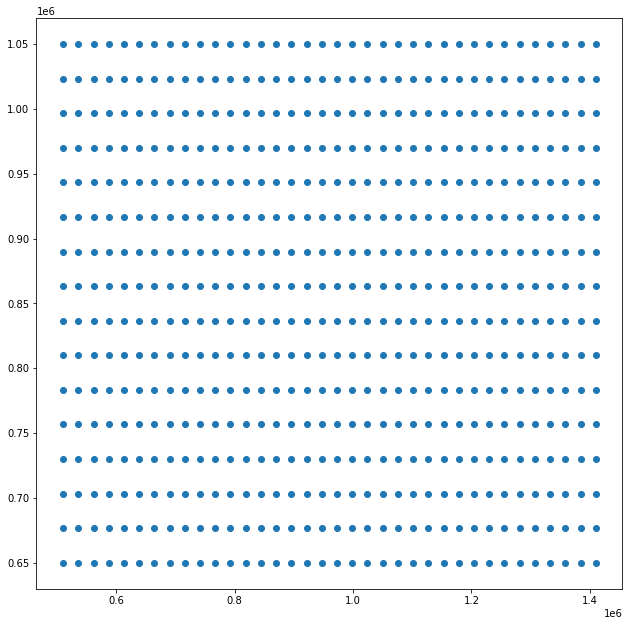

In [299]:
# plot out pia mesh

fig, ax = pyplot.subplots()
fig.set_size_inches(10.5, 10.5)
points = mesh_dict['l6b'].vertices
ax.scatter(x = points[:,0], y = points[:,2])

In [301]:
l6bpoints = mesh_dict['l6b'].vertices

lay6b_df = pd.DataFrame()
lay6b_df['x'] = l6bpoints[:,0]
lay6b_df['y'] = l6bpoints[:,1]
lay6b_df['z'] = l6bpoints[:,2]
lay6b_df

,x,y,z
0,510000.0,9.897150e+05,650000.0000
1,510000.0,1.004305e+06,676666.6875
2,510000.0,1.009412e+06,703333.3125
3,510000.0,1.013397e+06,730000.0000
4,510000.0,1.017467e+06,756666.6875
...,...,...,...
571,1410000.0,9.329878e+05,756666.6875
572,1410000.0,9.271438e+05,730000.0000
573,1410000.0,9.197706e+05,703333.3125
574,1410000.0,9.090289e+05,676666.6875


In [358]:
lay6b_df = lay6b_df.sort_values('x')
x_lay6b_df = lay6b_df.groupby(['x'])


,x,y,z
0,510000.0,9.897150e+05,6.500000e+05
1,510000.0,1.004305e+06,6.766667e+05
2,510000.0,1.009412e+06,7.033333e+05
3,510000.0,1.013397e+06,7.300000e+05
4,510000.0,1.017467e+06,7.566667e+05
5,510000.0,1.021241e+06,7.833333e+05
6,510000.0,1.024215e+06,8.100000e+05
7,510000.0,1.035846e+06,8.366667e+05
8,510000.0,1.036668e+06,8.633333e+05
9,510000.0,1.031320e+06,8.900000e+05


In [442]:
arr = np.empty((0,3), int)
arr = np.vstack((arr, np.array([[1,2,3]])))
arr = np.vstack((arr, np.array([[4,5,6]])))

arr

array([[1, 2, 3],
       [4, 5, 6]])

In [90]:
min_x, max_x

(48336.0, 434384.0)

In [88]:
print(converted_minx ,converted_maxx ,converted_minz ,converted_maxz )

193344.0 1737536.0 593040.0 1115160.0


In [150]:
converted_minx = min_x*4
converted_maxx = max_x*4

converted_minz = min_z*40
converted_maxz = max_z*40

new_mesh_dict = {}

for mesh_key in mesh_dict.keys():
    
    new_mesh_dict[mesh_key] = mesh_dict[mesh_key].vertices
    
    layer_verts = mesh_dict[mesh_key].vertices

    verts_df = pd.DataFrame()
    verts_df['x'] = layer_verts[:,0]
    verts_df['y'] = layer_verts[:,1]
    verts_df['z'] = layer_verts[:,2]

    xverts_df = verts_df.sort_values('x')
    xverts_df = verts_df.groupby(['x'])
    
    zverts_df = verts_df.sort_values('z')
    zverts_df = verts_df.groupby(['z'])
    
    if mesh_key == 'pia':
        break

    # this dict will help us to navigate through extending the x and then extanding the z 
    # mesh rows 
    xz_navigation_dict = {'x': [xverts_df, 'z', converted_minz, converted_maxz], 
                          'z': [zverts_df, 'x', converted_minx, converted_maxx]}
    
    for key, list_values in xz_navigation_dict.items():

        
        for x, yz_df in list_values[0]: # group by group in xverts_df or zverts_df
            
            m, b = np.polyfit(x = yz_df[list_values[1]], y = yz_df['y'], deg = 1)
            yz_df = yz_df.sort_values([list_values[1]]).reset_index()
            
            # plot
            #fig, ax = pyplot.subplots()
            #fig.set_size_inches(10.5, 2.5)
            #ax.scatter(x = yz_df[list_values[1]], y = yz_df['y'])

            # now draw a line from the first point to min_x w/ the slope

            # find the y value at x = 48336
            # find delta z for min
            dz1 = yz_df.loc[0, list_values[1]] - list_values[2]
            dy1 = m*dz1
            additional_y1 = yz_df.loc[0, 'y']-dy1

            # find delta z for max
            dz2 = yz_df.loc[len(yz_df)-1, list_values[1]] - list_values[3]
            dy2 = m*dz2
            additional_y2 = yz_df.loc[len(yz_df)-1, 'y']-dy2

            # plot additional points 
            #ax.plot([yz_df.loc[0, list_values[1]], list_values[2]], [yz_df.loc[0, 'y'], additional_y1])
            #ax.plot([yz_df.loc[len(yz_df)-1, list_values[1]], list_values[3]], [yz_df.loc[len(yz_df)-1, 'y'], additional_y2])
            
            
            # these all look good! add them to the mesh verts 
            # if mesh dict = x:
            if key == 'x':
                minz_coords = np.array([x, additional_y1, list_values[2]])
                maxz_coords = np.array([x, additional_y2, list_values[3]]) 
                
                # add min z pt
                new_mesh_dict[mesh_key] = np.vstack((new_mesh_dict[mesh_key], minz_coords))
                # add max z pt 
                new_mesh_dict[mesh_key] = np.vstack((new_mesh_dict[mesh_key], maxz_coords))
                
            if key == 'z':
                minx_coords = np.array([list_values[2], additional_y1, x])
                maxx_coords = np.array([list_values[3], additional_y2, x])
                
                # add min z pt
                new_mesh_dict[mesh_key] = np.vstack((new_mesh_dict[mesh_key], minx_coords))
                # add max z pt 
                new_mesh_dict[mesh_key] = np.vstack((new_mesh_dict[mesh_key], maxx_coords))





In [550]:
pd.DataFrame(new_mesh_dict['l6b'], columns = ['x','y','z']).sort_values('x').reset_index(drop = True)

,x,y,z
0,193344.0,1.066812e+06,8.366667e+05
1,193344.0,1.023546e+06,6.500000e+05
2,193344.0,1.039273e+06,6.766667e+05
3,193344.0,1.042586e+06,7.033333e+05
4,193344.0,1.044779e+06,7.300000e+05
...,...,...,...
675,1737536.0,8.854567e+05,7.033333e+05
676,1737536.0,8.728594e+05,6.766667e+05
677,1737536.0,8.675274e+05,6.500000e+05
678,1737536.0,9.309402e+05,8.900000e+05


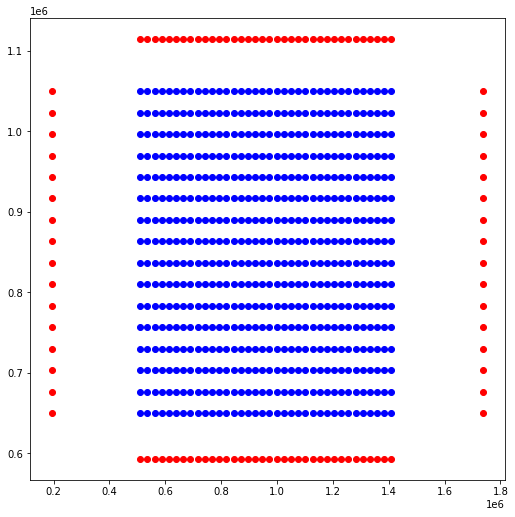

In [188]:
yz_df



points = new_mesh_dict['l6b']

fig, ax = pyplot.subplots()
fig.set_size_inches(8.5, 8.5)

# plot the last 10 points as red
ax.scatter(x = points[-104:,0], y = points[-104:,2], c = 'red')

# plot the rest as blue 
ax.scatter(x = points[:576,0], y = points[:576,2], c = 'blue')


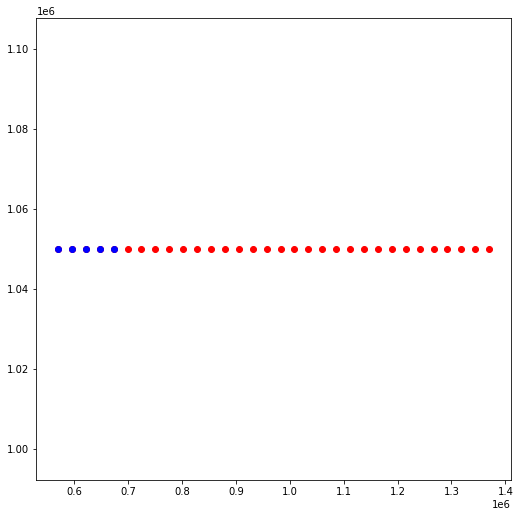

In [187]:
yz_df

# graph these in order 

fig, ax = pyplot.subplots()
fig.set_size_inches(8.5, 8.5)

# plot the last 10 points as red
ax.scatter(x = yz_df['x'].tolist(), y = yz_df['z'].tolist(), c = 'red')

ax.scatter(x = yz_df['x'].tolist()[:5], y = yz_df['z'].tolist()[:5], c = 'blue')

# plot the rest as blue 



In [183]:
len(points)-105

217

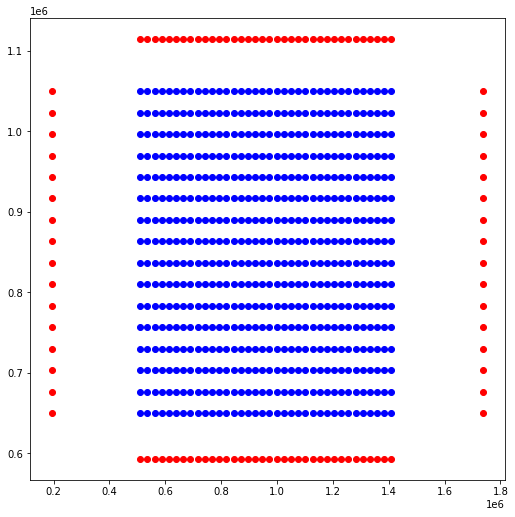

In [191]:
# graph these verts 
%matplotlib inline

points = new_mesh_dict['l6b']

fig, ax = pyplot.subplots()
fig.set_size_inches(8.5, 8.5)

# plot the last 10 points as red
ax.scatter(x = points[-104:,0], y = points[-104:,2], c = 'red')

# plot the rest as blue 
ax.scatter(x = points[:576,0], y = points[:576,2], c = 'blue')


In [252]:
n6b_df = pd.DataFrame(new_mesh_dict['l6b'], columns = ['x', 'y', 'z']).sort_values('z').reset_index(drop = True).reset_index()
n6b_df = n6b_df.groupby('z')

n6b_df

In [253]:
list(n6b_df.groups.keys())[0]
(n6b_df.groups[list(n6b_df.groups.keys())[0]])

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35],
           dtype='int64')

In [439]:
# create helper functions
def triangulate_grid_rows(row_1_idxs, row_2_idxs):
    
    '''
    creates the faces for two rows with equal number of indices 
    
    i.e [1,2,3], [4,5,6] -> [[4,1,2], [4,5,2], [5,2,3], [5,6,3]]
        
    
    '''
    
    faces = []
    # start at the bottom row, makt 2 clockwise triangles from each point
    # stop at the last index
    for i in range(len(row_2_idxs[:-1])):
        faces.append([row_2_idxs[i], row_1_idxs[i], row_1_idxs[i+1]])
        faces.append([row_2_idxs[i], row_2_idxs[i+1], row_1_idxs[i+1]])
    return np.array(faces)

triangulate_grid_rows([1,2,3], [4,5,6])


def verts_to_df(vertices):
    '''
    takes grid like vertices and puts them into a df in order and pulls out the index as a column \
    
    '''
    return pd.DataFrame(vertices, columns = ['x', 'y', 'z']).sort_values(['z', 'x']).reset_index(drop = True).reset_index()
    

In [527]:
new_mesh_dict['l6b'].shape

(680, 3)

In [440]:
def create_faces(mesh_verts):
    faces = np.empty((0,3), int)
    # put mesh vertices into dataframe and group by the z parameter so we can go row by row 
    # sort by z, reset index drop, then use reset index to pull out new index as 'index' column. then group by
    mesh_vert_df = verts_to_df(mesh_verts).groupby('z')
    pd.DataFrame(mesh_verts, columns = ['x', 'y', 'z']).sort_values(['z', 'x']).reset_index(drop = True).reset_index().groupby('z')

    # go z value by z value (row by row)
    previous_indices = []
    for z, zdf in mesh_vert_df:

        # if this is the first row, continue 
        if previous_indices == []:
            previous_indices = list(zdf['index'])
            continue

        current_indices = list(zdf['index'])


        # iterate through verts 
        # first row:
        if len(previous_indices) < len(zdf):
            # draw the first triangle 
            faces = np.vstack((faces, [current_indices[0], previous_indices[0], current_indices[1]]))

            # draw the middle triangels 
            # TODO - pull out as helper function! 
            middle_faces = triangulate_grid_rows(previous_indices, current_indices[1:-1])
            faces = np.vstack((faces, middle_faces))

            # draw the final triangles 
            faces = np.vstack((faces, [current_indices[-1], current_indices[-2], previous_indices[-1]]))
        # last row: 
        elif len(zdf) < len(previous_indices):
            # first triangle
            faces = np.vstack((faces, [current_indices[0], previous_indices[0], previous_indices[0]]))
            # middle triangles 
            middle_faces = triangulate_grid_rows(previous_indices[1:-1], current_indices)
            faces = np.vstack((faces, middle_faces))    
            # last triangle 
            faces = np.vstack((faces, [current_indices[-1], previous_indices[-1], previous_indices[-2]]))

        else:
            faces = np.vstack((faces, triangulate_grid_rows(previous_indices, current_indices)))

        previous_indices = list(zdf['index'])

    return faces
faces = create_faces(new_mesh_dict['l23'])


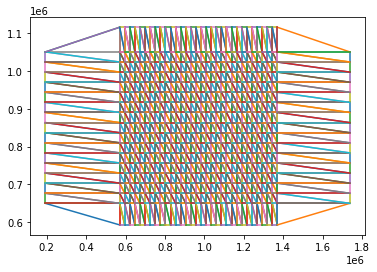

In [545]:
# plot the faces of one of the meshes

fig, ax = plt.subplots()

verts_df = pd.DataFrame(new_mesh_dict['l23'], columns = ['x', 'y', 'z']).sort_values(['z', 'x']).reset_index(drop = True).reset_index()


faces = create_faces(new_mesh_dict['l23'])

for face in faces:
    v1, v2, v3 = verts_df.loc[face[0]], verts_df.loc[face[1]], verts_df.loc[face[2]]
    plt.plot([v1[1], v2[1]], [v1[3], v2[3]])
    plt.plot([v2[1], v3[1]], [v2[3], v3[3]])
    plt.plot([v3[1], v1[1]], [v3[3], v1[3]])
    
# looks great!

In [455]:
new_mesh_dict.keys()

dict_keys(['l23', 'l4', 'l5', 'l6a', 'l6b', 'wm', 'pia'])

In [457]:
# create the new mesh for every layer except pia 

extended_mesh_dict = {}
for mesh_name in new_mesh_dict.keys():
    
    if mesh_name == 'pia':
        # just append the old pia 
        extended_mesh_dict['pia'] = mesh_dict['pia']
    
    else:
        verts_in_order_df = verts_to_df(new_mesh_dict[mesh_name])
        verts_in_order = np.array(verts_in_order_df.drop(['index'], axis= 1))

        faces = create_faces(new_mesh_dict[mesh_name])


        extended_mesh_dict[mesh_name] = trimesh_io.Mesh(verts_in_order, faces)
        
# suspicious that l6b has different number of verts 

In [469]:
extended_mesh_dict

{'l23': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 'l4': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 'l5': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 'l6a': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 'l6b': <trimesh.Mesh(vertices.shape=(680, 3), faces.shape=(1254, 3))>,
 'wm': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 'pia': <trimesh.Mesh(vertices.shape=(322, 3), faces.shape=(589, 3))>}

In [478]:
# figure out how to export
extended_mesh_dict[meshname].faces.astype(float)

TrackedArray([[ 32.,   0.,  33.],
              [ 33.,   0.,   1.],
              [ 33.,  34.,   1.],
              ...,
              [606., 573., 574.],
              [606., 607., 574.],
              [607., 575., 574.]])

In [521]:
extended_mesh_dict['l6b'].vertices

TrackedArray([[ 510000.        ,  984609.15719795,  593040.        ],
              [ 535714.3125    ,  990879.50168651,  593040.        ],
              [ 561428.5625    ,  988888.75589176,  593040.        ],
              ...,
              [1358571.375     ,  977896.97399078, 1115160.        ],
              [1384285.75      ,  968603.29898075, 1115160.        ],
              [1410000.        ,  964754.68218814, 1115160.        ]])

In [523]:
extended_mesh_dict['l6b'].vertices/[4,4,40]

TrackedArray([[127500.        , 246152.28929949,  14826.        ],
              [133928.578125  , 247719.87542163,  14826.        ],
              [140357.140625  , 247222.18897294,  14826.        ],
              ...,
              [339642.84375   , 244474.2434977 ,  27879.        ],
              [346071.4375    , 242150.82474519,  27879.        ],
              [352500.        , 241188.67054703,  27879.        ]])

In [525]:
# figure out how to export

from neuroglancer_scripts.mesh import save_mesh_as_precomputed

foldername = 'extended_layer_meshes'

mesh_name_to_numbers = { 'l23': '23', 'l4': '4', 'l5': '5', 'l6a':'64', 'l6b':'68', 'wm':'33', 'pia':'914'}

for meshname in extended_mesh_dict:
    mesh_number = mesh_name_to_numbers[meshname]
    filename = os.path.join(foldername, mesh_number)
    with open(filename, 'wb') as fp:
        save_mesh_as_precomputed(fp, extended_mesh_dict[meshname].vertices, 
                                 extended_mesh_dict[meshname].faces.astype('uint32'))
    with open(filename + ':0', 'w') as fp:
        d = {'fragments':[mesh_number]}
        json.dump(d, fp)



Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32
Vertex coordinates will be converted to float32


In [510]:
# now try immporting these 

test_mesh_dict={}
mesh_folder = 'extended_layer_meshes'
for filename in [x for x in os.listdir(mesh_folder) if ('0' not in x and '.' not in x)]:

    filepath = os.path.join(mesh_folder, filename)
    with open(filepath,'rb') as fp:
        verts,faces = read_precomputed_mesh(fp)
    mesh = trimesh_io.Mesh(verts, faces)
    filename = filepath.split('/')[1]
    test_mesh_dict[filename]=mesh
test_mesh_dict


{'68': <trimesh.Mesh(vertices.shape=(680, 3), faces.shape=(1254, 3))>,
 '33': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 '914': <trimesh.Mesh(vertices.shape=(322, 3), faces.shape=(589, 3))>,
 '64': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 '23': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 '4': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>,
 '5': <trimesh.Mesh(vertices.shape=(608, 3), faces.shape=(1118, 3))>}

In [504]:
with open(filepath,'rb') as fp:
    print(pd.DataFrame(fp))

                          0
0  b'{"fragments": ["33"]}'


In [491]:
filepath

'extended_layer_meshes/33:0'

In [492]:
test_mesh_dict

{}

In [562]:
import tools

In [554]:
tools.create_faces

array([[ 510000.        ,  989715.        ,  650000.        ],
       [ 510000.        , 1004305.        ,  676666.6875    ],
       [ 510000.        , 1009412.375     ,  703333.3125    ],
       ...,
       [1737536.        ,  928638.66533172, 1050000.        ],
       [ 193344.        , 1062572.25479212, 1115160.        ],
       [1737536.        ,  939420.12963012, 1115160.        ]])

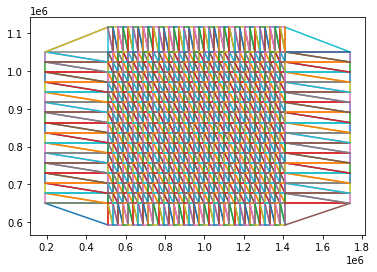

In [559]:
fig, ax = plt.subplots()

verts_df = pd.DataFrame(tools.extend_vertices(mesh_dict['l6b'].vertices), columns = ['x', 'y', 'z']).sort_values(['z', 'x']).reset_index(drop = True).reset_index()


faces = create_faces(tools.extend_vertices(mesh_dict['l6b'].vertices))

for face in faces:
    v1, v2, v3 = verts_df.loc[face[0]], verts_df.loc[face[1]], verts_df.loc[face[2]]
    plt.plot([v1[1], v2[1]], [v1[3], v2[3]])
    plt.plot([v2[1], v3[1]], [v2[3], v3[3]])
    plt.plot([v3[1], v1[1]], [v3[3], v1[3]])